### Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Modulos de scikit learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

# Carga de datos

La base de datos _California Housing Prices_ contiene datos sobre el precio de casas en California, junto con la información de la casa como número de pisos, número de cuartos, etc. En este trabajo, se va a realizar un modelo de regresión lineal para predecir el precio de casas según las variables _median\_income_ (la mediana de los ingresos de las casas aledañas a la que está en venta) y _Housing\_Median\_Age_ (mediana de las edades de las casas de una manzana).

Liga a la base de datos: https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df = df[['median_income', 'median_house_value', 'housing_median_age']]
df.head()

,median_income,median_house_value,housing_median_age
0,8.3252,452600.0,41.0
1,8.3014,358500.0,21.0
2,7.2574,352100.0,52.0
3,5.6431,341300.0,52.0
4,3.8462,342200.0,52.0


# Estadistica descriptiva

In [5]:
df.describe()

,median_income,median_house_value,housing_median_age
count,20640.000000,20640.000000,20640.000000
mean,3.870671,206855.816909,28.639486
std,1.899822,115395.615874,12.585558
min,0.499900,14999.000000,1.000000
25%,2.563400,119600.000000,18.000000
50%,3.534800,179700.000000,29.000000
75%,4.743250,264725.000000,37.000000
max,15.000100,500001.000000,52.000000


En esta sección, se puede observar la distribución de la variable objetivo, la cual se puede describir como una distribución sesgada a la derecha, con una importante concentración de outliers entre los 450 y 550 mil dolares. Para evitar que el modelo se vea afectado negativamente por datos atípicos, se decidió eliminar los registros que se encuentren por encima del percentil 90.

<Axes: >

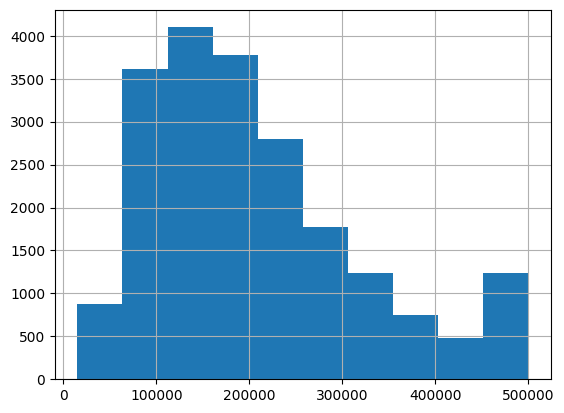

In [6]:
df.median_house_value.hist()

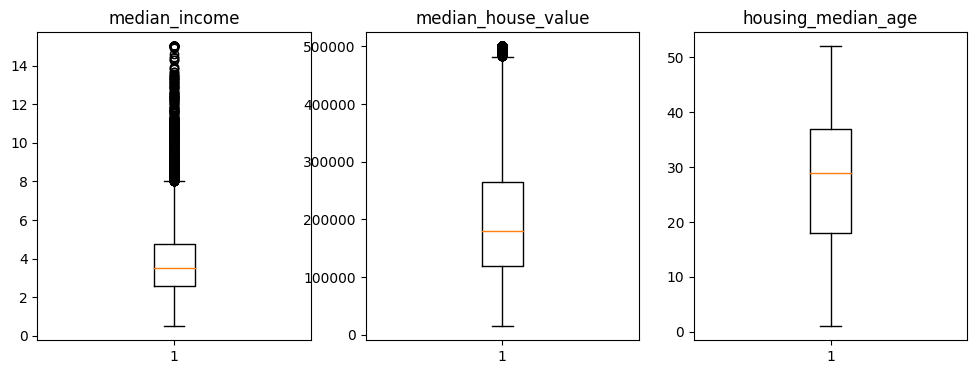

In [7]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4))

col = 0
for i in df.columns:
  axis[col].boxplot(df[i])
  axis[col].set_title(i)

  col =col + 1

In [8]:
df = df[df["median_house_value"] < df["median_house_value"].quantile(0.90)]

<Axes: >

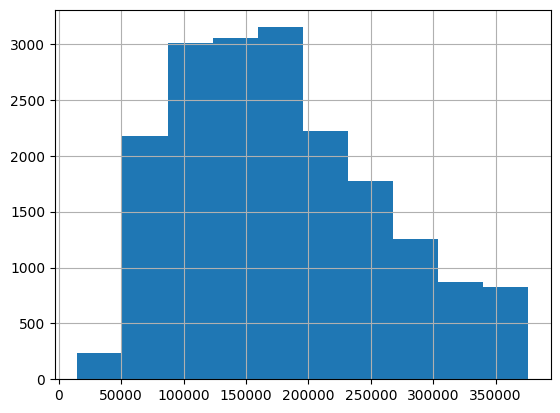

In [9]:
df.median_house_value.hist()

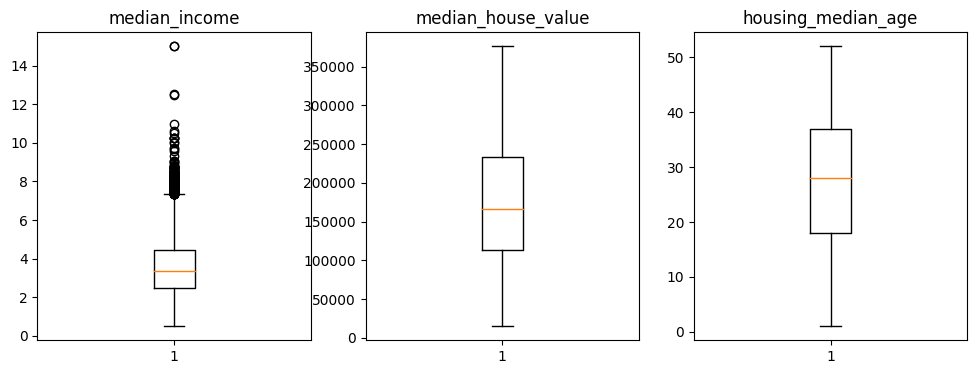

In [10]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4))

col = 0
for i in df.columns:
  axis[col].boxplot(df[i])
  axis[col].set_title(i)

  col =col + 1

# División del DataSet

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop("median_house_value", axis = 1),
                                                                    df["median_house_value"], test_size=0.3, random_state=42)

# Aplicacion del modelo

In [12]:
#Crear objeto del modelo
dtr = DecisionTreeRegressor(random_state=0)
#Usar método fit para ajustar el modelo
reg = dtr.fit(x_train, y_train)

El score inicial del modelo se puede considerar muy bueno al ser del 98.48%. A continuación se va a modificar ciertos hiperparámetros para conseguir un modelo más ajustado a los datos.

In [13]:
reg.score(x_train, y_train)

0.9847986533330964

## Ajuste del modelo

En este punto, se decidió ajustar 4 hiperparámetros con diferentes valores.

1.   Max_depth: la máxima profundidad del árbol de decisión
2.   Min\_samples\_split: La mínima cantidad de registros para que se divida un nodo
3.   Min\_samples\_leaf: a mínima cantidad de registros que deben existir en una hoja



In [14]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,2,4]
}

grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


Al utilizar la función GridSearchCV, se pudo escoger los mejores hiperparámetros entre los valores dados en el diccionario param\_grid. Con esto, se puede realizar un nuevo entrenamiento con dichos hiperparámetros.

In [15]:
best_dtr = DecisionTreeRegressor(**best_params, random_state=42)
best_dtr.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [16]:
reg.score(x_train, y_train)

0.9847986533330964

# Predicción

En esta sección se utilizó la división del dataset destinado para probar la calidad del modelo. Posteriormente se comparó con los valores reales del dataset de prueba

La métrica a utilizar para validar la calidad del modelo es el MAPE o Mean Absolute Percentage Error en inglés. Con esta métrica de medición del error, se puede evaluar de forma porcentual el error de la predicción. Según la tabla de interpretación de esta métrica de error, un valor de MAPE entre 20 y 50%, muesta un modelo razonable, lo cual se puede observar en este caso.

In [17]:
y_pred = best_dtr.predict(x_test)

print ("MAPE: ", metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE:  0.348842904585067


En esta gráfica se puede observar como los datos reales siguen una tendencia positiva, sin embargo esta no es marcada, pues los datos se encuentran bastante dispersos. Las predicciones obtenidas siguen la misma tendencia que los valores reales y esto se puede evidenciar con el valor del MAPE de la predicción, además de que se observa cierta dispersión de los valores predecidos. Con esto, se puede concluir que el modelo de regresión lineal simple puede describir de manera aceptable los precios de las casas en California.

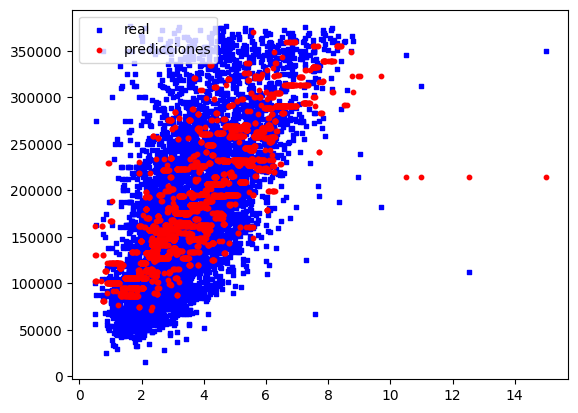

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x_test.median_income, y_test, s=10, c='b', marker="s", label='real')
ax1.scatter(x_test.median_income,y_pred, s=10, c='r', marker="o", label='predicciones')
plt.legend(loc='upper left')
plt.show()